In [3]:
import pandas as pd
import numpy as np
import sqlite3 as sql 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from itertools import product
import sklearn
%matplotlib inline

In [4]:
conn = sql.connect("data/calls.db")
query = '''select * from calls'''

In [5]:
import session_info
session_info.show()

In [6]:
df = pd.read_sql_query(query,conn)
df.head()

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
0,947429,-719,12,42.130000,Suspicious,Yes,1,95,Voip,2023-07-23 09:04:00,Fully Charged,Scam
1,540498,116,3,29.900000,Unlikely,Yes,0,91,Mobile,2023-09-05 20:11:00,Fully Charged,Scam
2,434243,29,16,723.460000,Very Suspicious,Yes,2,91,Voip,2023-12-16 11:03:00,Charging,Scam
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
4,969179,312,19,0.000000,Unlikely,Yes,0,91,Telegram,2023-11-10 15:53:00,Fully Charged,Scam


## 1.Overview of Data Instances and Values

In [7]:
df.describe()



,ID,Call Duration,Call Frequency,Financial Loss,Previous Contact Count
count,12000.000000,12000.000000,12000.000000,10597.000000,12000.000000
mean,551248.413500,100.259417,10.698167,95.128864,1.861167
std,257920.330881,288.006415,5.861791,191.516365,1.765310
min,100017.000000,-787.000000,2.000000,-896.400000,0.000000
25%,332326.250000,-30.000000,6.000000,0.000000,0.000000
50%,545820.000000,45.000000,9.000000,11.719081,2.000000
75%,776049.250000,282.000000,15.000000,84.264405,3.000000
max,999709.000000,822.000000,27.000000,1055.440000,8.000000


We check take a look at the statistics of the dataframe for a general overview and any inconsistencies in data. (e.g. negative values).  

We notice that there exists negative values for call duration and financial loss which do not are not accurate 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      12000 non-null  int64  
 1   Call Duration           12000 non-null  int64  
 2   Call Frequency          12000 non-null  int64  
 3   Financial Loss          10597 non-null  float64
 4   Flagged by Carrier      12000 non-null  object 
 5   Is International        12000 non-null  object 
 6   Previous Contact Count  12000 non-null  int64  
 7   Country Prefix          12000 non-null  object 
 8   Call Type               12000 non-null  object 
 9   Timestamp               12000 non-null  object 
 10  Device Battery          12000 non-null  object 
 11  Scam Call               12000 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.1+ MB


<Axes: >

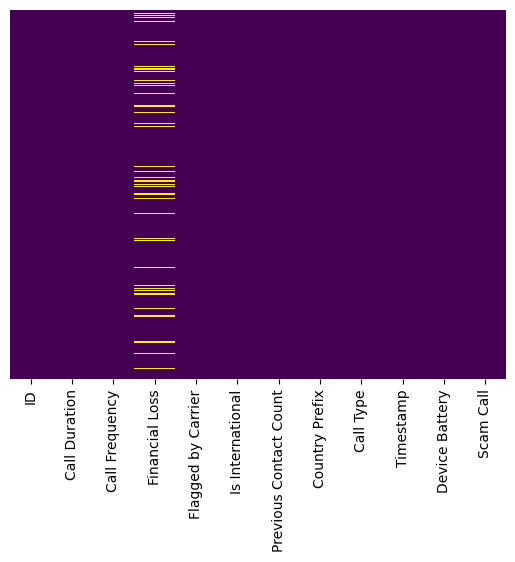

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
neg = ((df['Financial Loss'] < 0) & (df['Scam Call'] == 'Scam')).any()
print(neg)

True


In [11]:
exists = ((df['Financial Loss'].isnull()) & (df['Scam Call'] == 'Scam')).any()
print(exists)

False


We then take a look at the columns of the dataframe to check for any **NON-NULL** values, datatypes of columns as well as the number of rows.

We notice that there is an existence of **NULL** values for `Financial Loss` which will need to be handled. 
However note that we checked if any of the missing rows are labeled Scam. Since they are not we can simply replace the **NULL** values with 0.

However for negative values there seems to exist so we must handle it another way 

Following this we will now check the actl number of negative values as well as **NULL** values in each column

In [12]:
df.isnull().sum()

ID                           0
Call Duration                0
Call Frequency               0
Financial Loss            1403
Flagged by Carrier           0
Is International             0
Previous Contact Count       0
Country Prefix               0
Call Type                    0
Timestamp                    0
Device Battery               0
Scam Call                    0
dtype: int64

We see that the only column with **NULL** values is Financial Loss, we perform further analysis to find out more about negative values as well


In [13]:
num_df = df.select_dtypes(include=['int64','float64'])
(num_df<0).sum()

ID                           0
Call Duration             3344
Call Frequency               0
Financial Loss             284
Previous Contact Count       0
dtype: int64

In [14]:
num_df_nan = num_df[num_df.isnull()]
(num_df_nan<0).sum()

ID                        0
Call Duration             0
Call Frequency            0
Financial Loss            0
Previous Contact Count    0
dtype: int64

In order to find out number of negative Values we first filter out the categorical values. 

Then we check whether there exists any null values of `Financial Loss` in the rows where `Call Duration` is negative

Turns out that there is no overlap hence we can handle the cases of Negative Values and **NULL** values seperately.

We will now check the percentage of Negative values and see how they should be handled

In [15]:

print("Percent of Negative Values (Call Duration): ",(df['Call Duration'] < 0).sum()/df['Call Duration'].count()*100)
print("Percent of Negative Values (Financial Loss): ",(df['Financial Loss'] < 0).sum()/df['Financial Loss'].count()*100)

Percent of Negative Values (Call Duration):  27.866666666666667
Percent of Negative Values (Financial Loss):  2.6800037746532035


We note that Percent of Negative values for Financial Loss is small so we can drop it
However for Call Duration, the percent is too high and requires imputation. We will choose either mean or median imputation depending on the skew later on

Next I will check whether for `Is International` and `Country Prefix` are consistent. Since our home country is Singapore, I assume anything without a *+65* is an International call

In [16]:
df['Local Routed'] = ((df['Country Prefix'] == '65') & (df['Is International'] == 'Yes')) 
df['Local Routed'] = df['Local Routed'].replace({True:'Yes',False:'No'})
df[df['Local Routed'] == 'Yes']

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call,Local Routed
6,179967,590,21,378.510000,Suspicious,Yes,1,65,Telegram,2024-01-02 10:22:00,Fully Charged,Scam,Yes
12,231771,116,10,5.861031,Unlikely,Yes,0,65,Voip,2023-09-15 01:48:00,Charging,Not Scam,Yes
32,658580,27,7,0.000000,Unlikely,Yes,2,65,Whats App,2023-11-29 03:14:00,Charging,Not Scam,Yes
39,861382,-574,9,8.926931,Unlikely,Yes,2,65,Mobile,2024-02-09 11:46:00,Charging,Not Scam,Yes
87,890053,142,13,44.216787,Unlikely,Yes,2,65,Voip,2023-11-15 06:57:00,Not Charging,Not Scam,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11940,271996,-583,3,NaN,Suspicious,Yes,1,65,Mobile,2023-02-28 04:19:00,Charging,Not Scam,Yes
11942,919975,630,3,NaN,Unlikely,Yes,4,65,Telegram,2023-03-24 07:11:00,Fully Charged,Not Scam,Yes
11956,680165,131,14,411.090000,Unlikely,Yes,2,65,WhatsApp,2023-09-28 22:31:00,Charging,Scam,Yes
11965,505077,307,9,-92.499488,Unlikely,Yes,1,65,Whats App,2023-02-23 22:32:00,Fully Charged,Not Scam,Yes


Interesting! We notice that there exists International Calls that have the Country Prefix of 65. This means that the call origins are maybe business related call centers or have been possibly falsified and hence we add an additional column `Local Routed` which will make it easier to reference in further analysis steps
  

Next step is Analysis so we will fill in the NULL values for now as it can be safely assumed to be true.

In [17]:
df['Financial Loss'] = df['Financial Loss'].fillna(0)
df

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call,Local Routed
0,947429,-719,12,42.130000,Suspicious,Yes,1,95,Voip,2023-07-23 09:04:00,Fully Charged,Scam,No
1,540498,116,3,29.900000,Unlikely,Yes,0,91,Mobile,2023-09-05 20:11:00,Fully Charged,Scam,No
2,434243,29,16,723.460000,Very Suspicious,Yes,2,91,Voip,2023-12-16 11:03:00,Charging,Scam,No
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam,No
4,969179,312,19,0.000000,Unlikely,Yes,0,91,Telegram,2023-11-10 15:53:00,Fully Charged,Scam,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,496033,116,15,0.000000,Unlikely,Yes,4,7,Voip,2023-05-03 14:32:00,Fully Charged,Not Scam,No
11996,730960,621,3,11.740000,Suspicious,Yes,0,MM,Landline,2023-08-04 00:16:00,Fully Charged,Scam,No
11997,806410,-27,4,102.450000,Suspicious,Yes,0,MM,Voip,2024-03-22 01:31:00,Not Charging,Scam,No
11998,481032,-127,9,0.000000,Unlikely,Yes,0,1,Landline,2023-07-11 17:04:00,Charging,Not Scam,No


## 2.Univariate Analysis

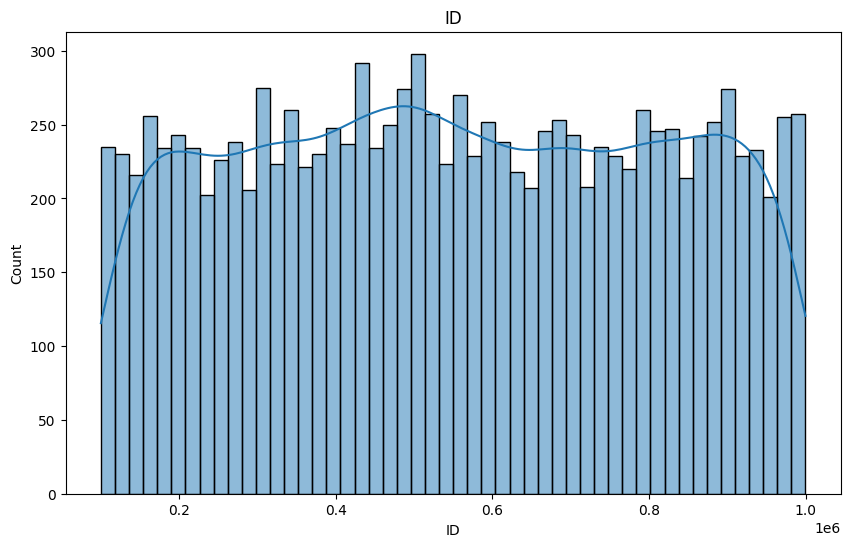

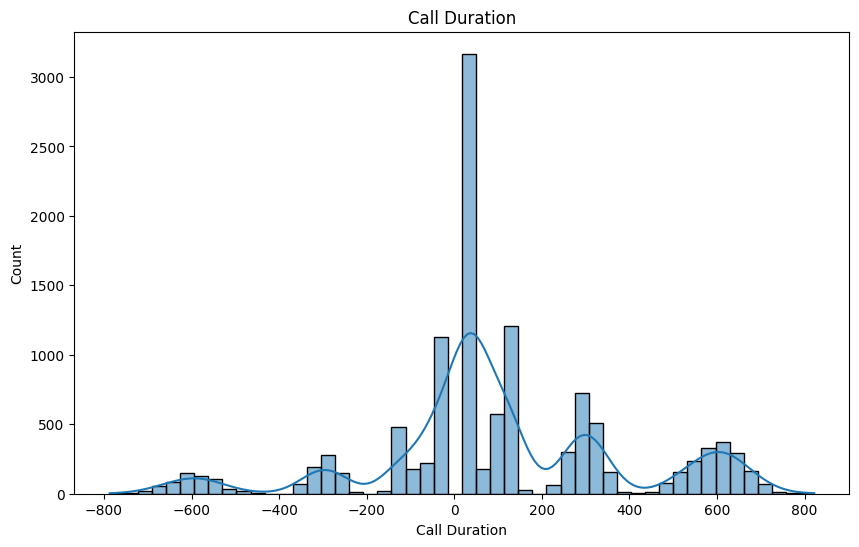

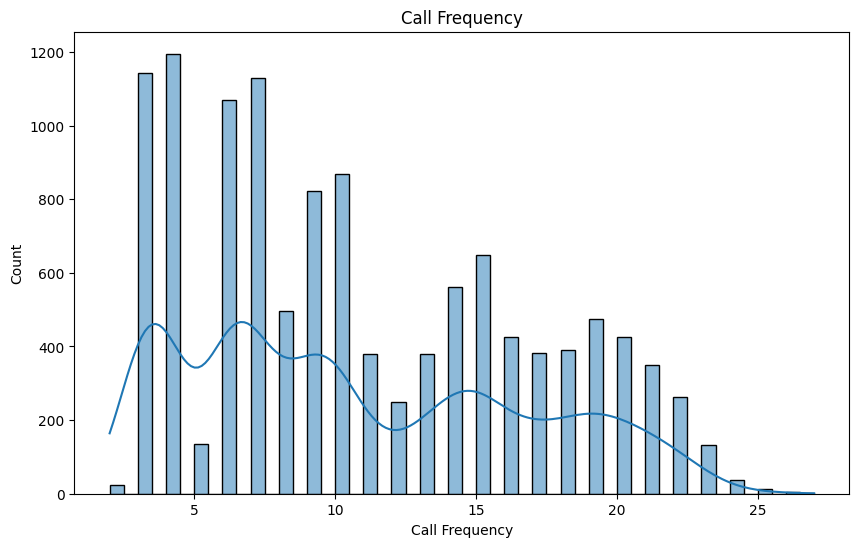

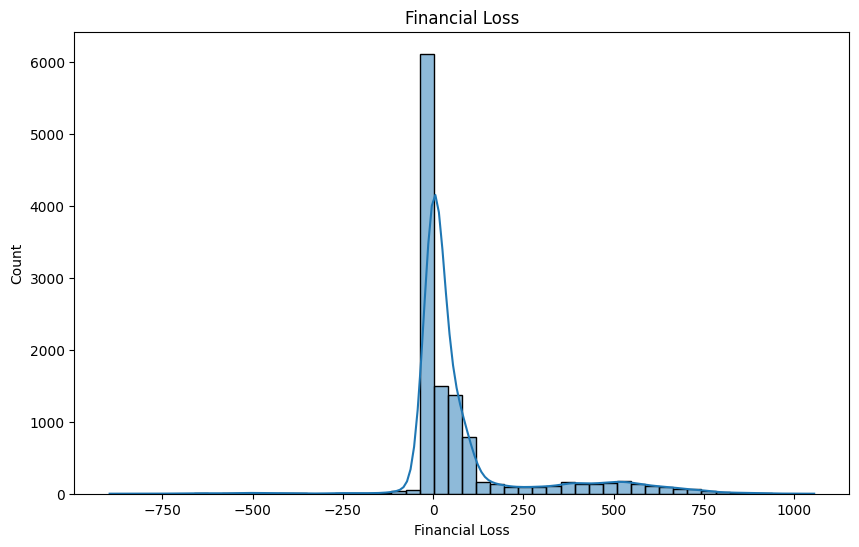

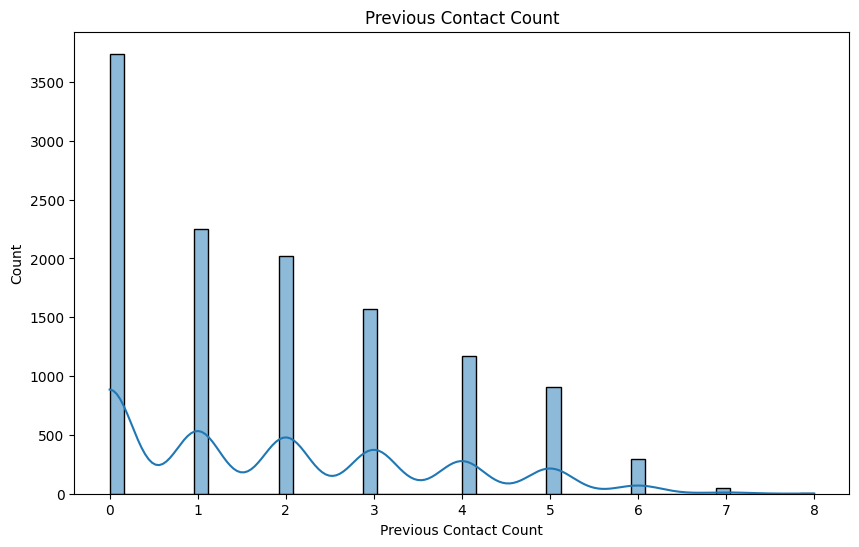

In [18]:


df_num = df.select_dtypes(include = ['int64','float64'])
for column in df_num.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_num[column], bins=50, kde=True)
    plt.title(column)
    plt.show()

We do a general univariate analysis on the numerical variables to see the general distribution.

 We notice that call frequency,call duration,financial loss and previous contact count are all skewed to the right which can make it harder for our models to learn we shall note this for later use.
 We also need to check for potential Outliers, however with the presence of Financial Loss and Call duration having negatives(Unreasonable) we will check after augmentation.

<Axes: xlabel='Local Routed', ylabel='count'>

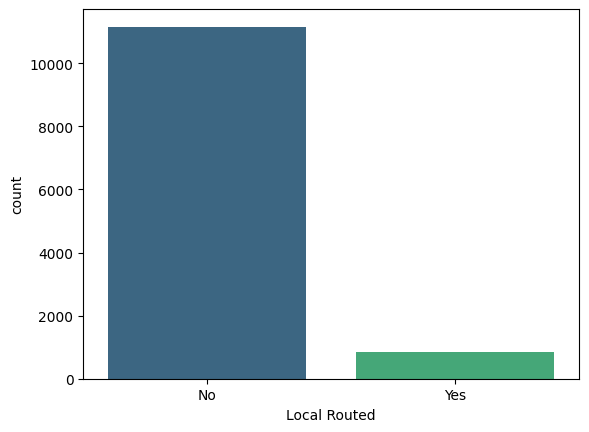

In [19]:
sns.countplot(data=df,x='Local Routed',hue = 'Local Routed', legend=False, palette='viridis')

<Axes: xlabel='Scam Call', ylabel='count'>

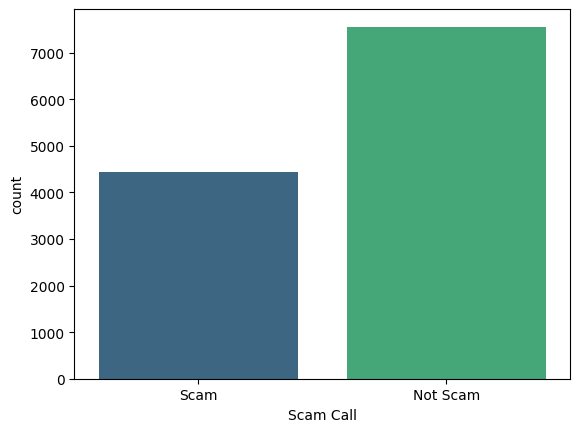

In [20]:
sns.countplot(data=df,x='Scam Call',hue='Scam Call',legend=False,palette='viridis')

We notice that there is an imbalance in the labels for the dataset, likely due to the presence of answered calls being more likely not scams, we have to consider this when we perform the train test split for model training later on to ensure test train sets are reprentative

In [21]:
categorical_features = df.select_dtypes(include='object')
for v in categorical_features:
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=df[v],
        nbinsx=len(df[v].unique()), 
        histnorm='percent'
    ))
    fig.update_layout(
        title=f"Histogram of {v}",
        xaxis_title=v,
        yaxis_title='Percentage',
    )
    fig.show()

We notice some interesting observations 
- Whatsapp is duplicated so there is need to fix this
- device battery conditons are fairly equal 
- call types are majority mobiles
- international calls are majority from 91(India) 
- the carrier flags are mostly unlikely , many scam calls probably end up unoticed
- Majority of the calls are not Local Routed, so we might no be able to use this as a decisive feature, we will further analyse later on to confirm.

with these observations we can roughly see what changes to make and what values of each category are most frequent 
this can help us with our feature selection for model selection but we will perform correlation analysis to get a better idea 

## 2. Bivariate Analysis

I now create my Train test split before further analysis to ensure that when I estimate generlization error using the test set, it is not overoptimistic.

Since I am conducting batch training with the same set of data and I can use the same random state, I will be able to use the same train test split for my model scripts.

I use sklearnst traintestsplit with stratify specifically as the `Scam Call` label is imbalanced so we will need to create a train test split representative of the data

In [22]:
df_train_set,df_test_set = train_test_split(df,test_size=0.2,stratify=df['Scam Call'],random_state=73)

We will use this same random_state(73) for data_processing during training of our models

In [23]:
calls = df_train_set.copy()

array([[<Axes: xlabel='ID', ylabel='ID'>,
        <Axes: xlabel='Call Duration', ylabel='ID'>,
        <Axes: xlabel='Call Frequency', ylabel='ID'>,
        <Axes: xlabel='Financial Loss', ylabel='ID'>,
        <Axes: xlabel='Previous Contact Count', ylabel='ID'>],
       [<Axes: xlabel='ID', ylabel='Call Duration'>,
        <Axes: xlabel='Call Duration', ylabel='Call Duration'>,
        <Axes: xlabel='Call Frequency', ylabel='Call Duration'>,
        <Axes: xlabel='Financial Loss', ylabel='Call Duration'>,
        <Axes: xlabel='Previous Contact Count', ylabel='Call Duration'>],
       [<Axes: xlabel='ID', ylabel='Call Frequency'>,
        <Axes: xlabel='Call Duration', ylabel='Call Frequency'>,
        <Axes: xlabel='Call Frequency', ylabel='Call Frequency'>,
        <Axes: xlabel='Financial Loss', ylabel='Call Frequency'>,
        <Axes: xlabel='Previous Contact Count', ylabel='Call Frequency'>],
       [<Axes: xlabel='ID', ylabel='Financial Loss'>,
        <Axes: xlabel='Call Durat

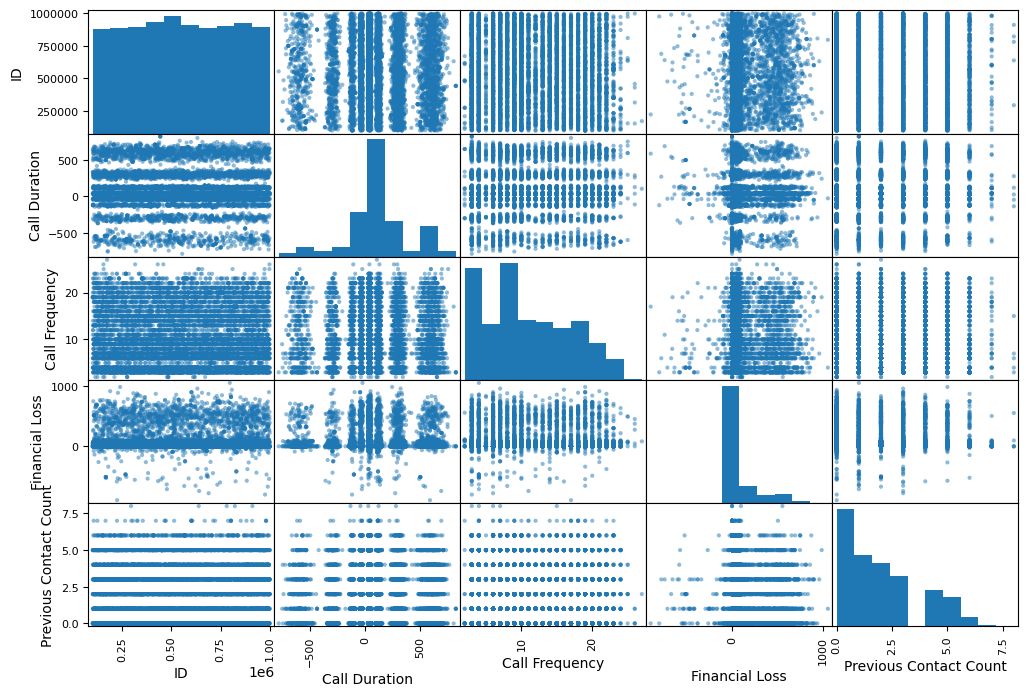

In [24]:
nums = calls.select_dtypes(include=['int64','float64']).columns
from pandas.plotting import scatter_matrix
scatter_matrix(calls[nums],figsize=(12,8))

<Axes: >

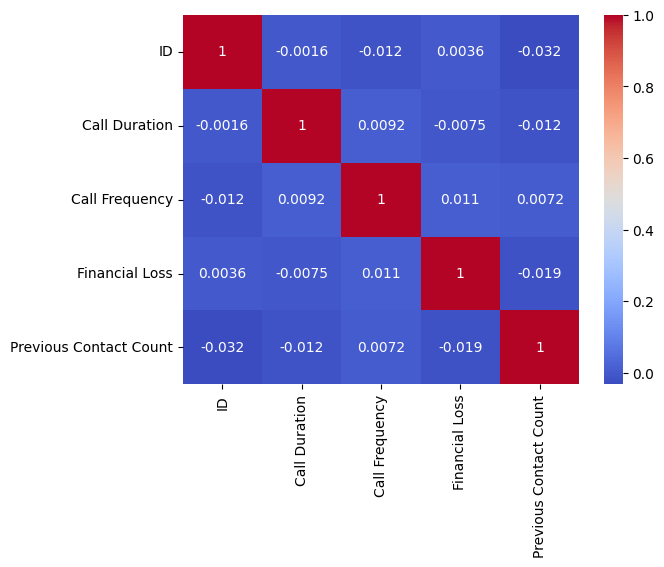

In [25]:
sns.heatmap(calls[nums].corr(),cmap='coolwarm',annot=True)

We check to see if there is any possibly correlation between the numerical values and it seems unlikely. note how we dont only use correlation number but also a scatter plot just in case if a non-linear relationship existed.

In [26]:
calls_cat = calls.select_dtypes(include = 'object')
cat_var1 = calls_cat.columns.tolist()
cat_var2 = cat_var1
cat_var_product = list(product(cat_var2,cat_var1,repeat=1))


In [27]:
result = []
for i in cat_var_product:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(sp.stats.chi2_contingency(pd.crosstab(calls_cat[i[0]], calls_cat[i[1]])))[1]))

In [28]:
chi_test_output = pd.DataFrame(result, columns = ["var1", "var2", 'coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index='var1', columns='var2', values='coeff')

var2,Call Type,Country Prefix,Device Battery,Flagged by Carrier,Is International,Local Routed,Scam Call,Timestamp
var1,,,,,,,,
Call Type,NaN,8.450962e-03,4.823761e-01,6.409861e-01,3.485004e-02,2.782205e-01,7.772805e-74,6.638303e-139
Country Prefix,8.450962e-03,NaN,1.949948e-01,7.609812e-02,0.000000e+00,0.000000e+00,2.978803e-175,2.953732e-167
Device Battery,4.823761e-01,1.949948e-01,NaN,2.907460e-03,1.888996e-01,4.557288e-01,8.790928e-01,3.518341e-57
Flagged by Carrier,6.409861e-01,7.609812e-02,2.907460e-03,NaN,3.350446e-01,1.005524e-01,1.473274e-93,5.849875e-56
Is International,3.485004e-02,0.000000e+00,1.888996e-01,3.350446e-01,NaN,1.357952e-12,5.831417e-12,5.232555e-29
Local Routed,2.782205e-01,0.000000e+00,4.557288e-01,1.005524e-01,1.357952e-12,NaN,2.031684e-03,3.814895e-29
Scam Call,7.772805e-74,2.978803e-175,8.790928e-01,1.473274e-93,5.831417e-12,2.031684e-03,NaN,1.645917e-29
Timestamp,6.638303e-139,2.953732e-167,3.518341e-57,5.849875e-56,5.232555e-29,3.814895e-29,1.645917e-29,NaN


We use the chi-test which is basically comparing observed results with expected results and check how likely it is that there is no correlation. The cross tab shown is filled with p-values, smaller showing that we reject the null hypothesis that there is no correlation.

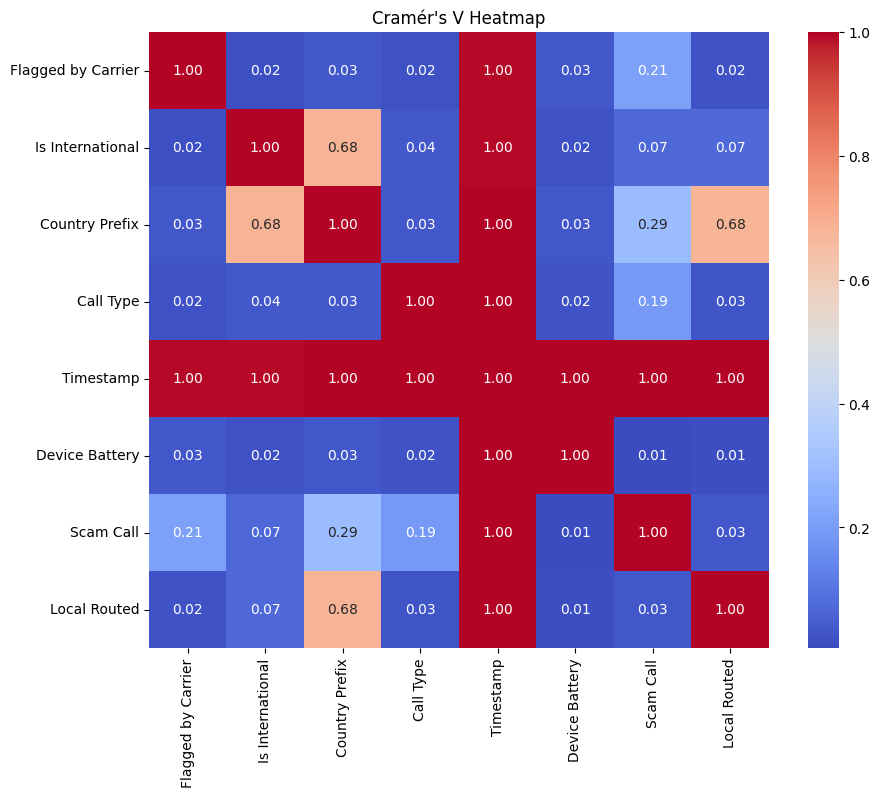

In [29]:
categorical_columns = calls_cat.columns
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)


for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(calls[col1], calls[col2])
            chi2, p, dof, ex = sp.stats.chi2_contingency(confusion_matrix)
            n = confusion_matrix.sum().sum()
            r, k = confusion_matrix.shape
            cramers_v = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
            cramers_v_matrix.loc[col1, col2] = cramers_v


cramers_v_matrix = cramers_v_matrix.astype(float)
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cramér's V Heatmap")
plt.show()



 Cramer V is the effect measurement so we can see how strong the correlation is between categorical variables, so far flagged by carrier, country prefix, call type seems the most correlated with scam call

C:\Users\yashv\AppData\Local\Temp\ipykernel_18936\865262922.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



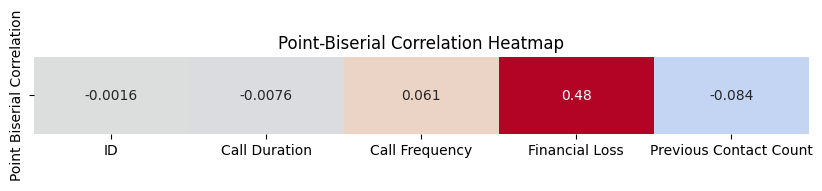

In [30]:
calls_num = calls.select_dtypes(include=['int64','float64'])
point_biserial_corr = {}
calls['Scam Call'] = calls['Scam Call'].replace({'Scam':1,'Not Scam':0})
for col in calls_num:
    corr, p_value = sp.stats.pointbiserialr(calls['Scam Call'], calls_num[col])
    point_biserial_corr[col] = corr

# Create a DataFrame for the heatmap
point_biserial_df = pd.DataFrame.from_dict(point_biserial_corr, orient='index', columns=['Point Biserial Correlation'])
# Plot heatmap
plt.figure(figsize=(10, 1))
sns.heatmap(point_biserial_df.T, annot=True, cmap='coolwarm', center=0, cbar=False)
plt.title("Point-Biserial Correlation Heatmap")
plt.show()



Since scam call is a natural dichotomy, we can use point-biserial correlation to find its correlation level to numerical values. Finanical Loss seems the highest. HOWEVER we must note that in order to meet the end goal of a real time scam detection, we cannot use finanical loss as a feature

## 3.Data Augmentation and ReAnalysis

From what we learnt from the above data, there is a few stuff we need to do to process it so that we can perform reanalysis and possibly see improvments in the correlation values

1. Fix Whatsapp and Whats app 
2. Fill missing values of Financial Loss so we can use those rows
3. Drop negative values of Financial Loss
4. Impute the negative values of call duration with the median instead
6. Perform Normalization of the numerical values that are measurments and not identifiers

In [31]:
import sklearn.preprocessing


calls = df_train_set.copy()

calls['Call Type'] = calls['Call Type'].apply(lambda x: 'WhatsApp' if x == 'Whats App' else x)


calls['Financial Loss'] = calls['Financial Loss'].fillna(0)


calls = calls[calls['Financial Loss'] >= 0]


median_call_duration = calls.loc[calls['Call Duration'] >= 0, 'Call Duration'].median()
calls.loc[calls['Call Duration'] < 0, 'Call Duration'] = median_call_duration

calls['Call Duration'] = np.sqrt(calls['Call Duration'])
calls['Call Frequency'] = np.sqrt(calls['Call Frequency'])
calls['Previous Contact Count'] = np.sqrt(calls['Previous Contact Count'])


normalizer = sklearn.preprocessing.Normalizer()
normalized_data = normalizer.fit_transform(calls[['Call Duration', 'Call Frequency', 'Financial Loss', 'Previous Contact Count']])
calls[['Call Duration', 'Call Frequency', 'Financial Loss', 'Previous Contact Count']] = pd.DataFrame(normalized_data, columns=['Call Duration', 'Call Frequency', 'Financial Loss', 'Previous Contact Count'], index=calls.index)


calls['Call Duration'] = np.sqrt(calls['Call Duration'])
calls['Call Frequency'] = np.sqrt(calls['Call Frequency'])
calls['Previous Contact Count'] = np.sqrt(calls['Previous Contact Count'])



We perform Normalisation to ensure relevant numerical values are standardized. This is important for models like SVM as they are sensitive to scale and for other models it can boost performance. Then we sqrt the values to try to ensure that it is not too skewed to one side, helping in training.

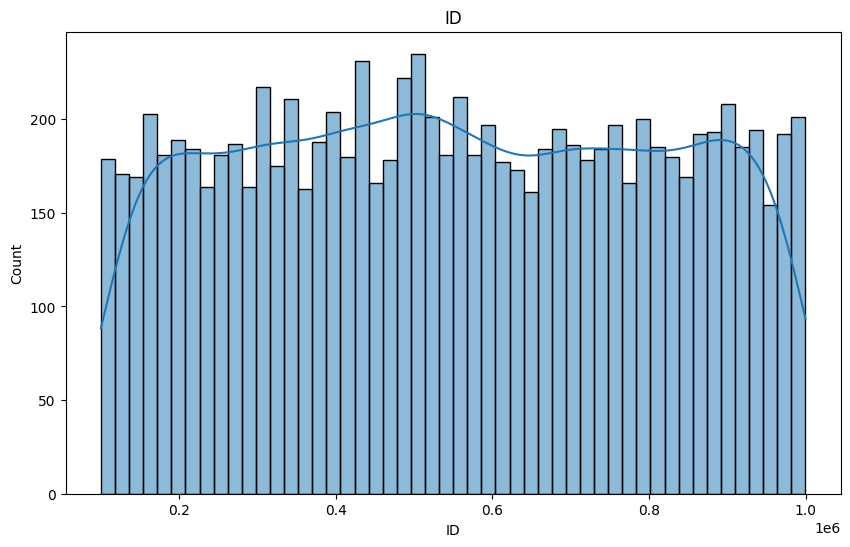

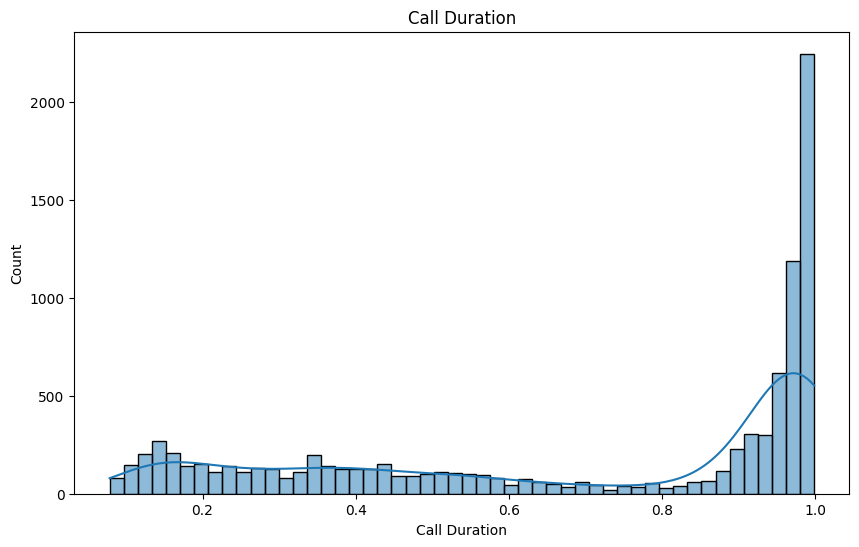

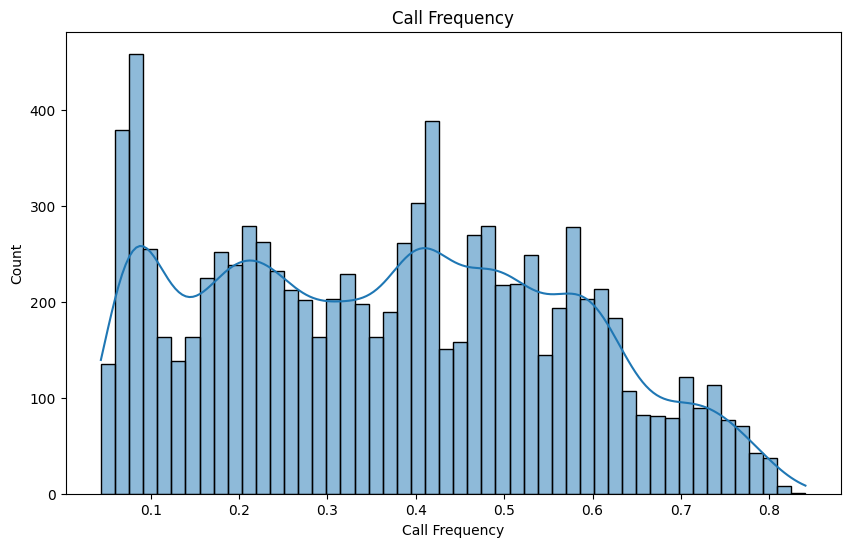

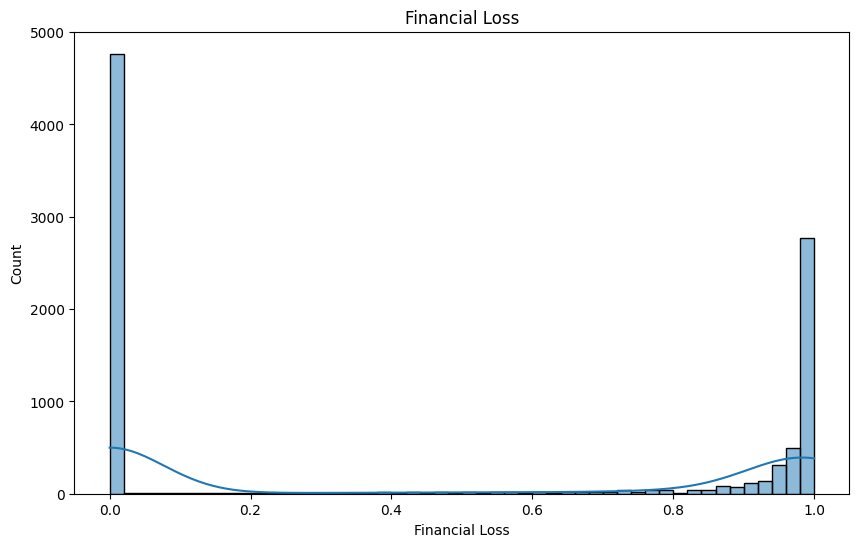

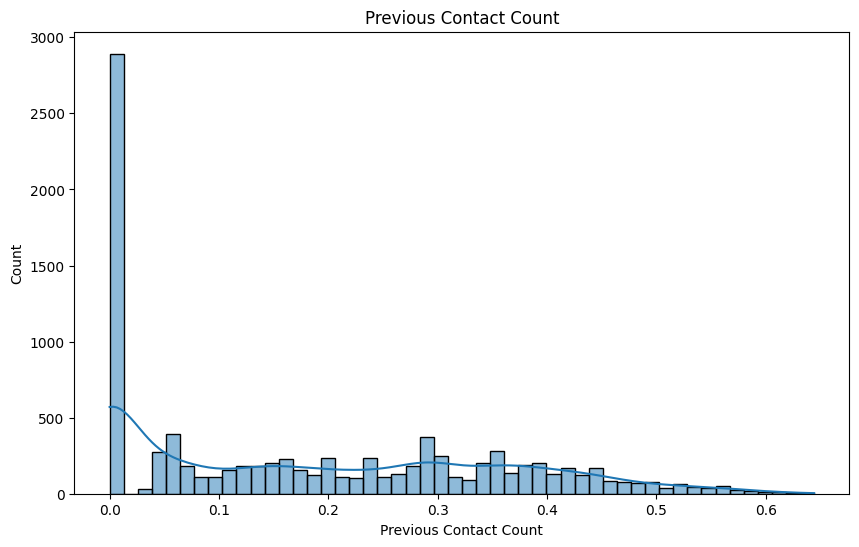

In [32]:
df_num = calls.select_dtypes(include = ['int64','float64'])
for column in df_num.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_num[column], bins=50, kde=True)
    plt.title(column)
    plt.show()

We not that even though the skew is still present, it is MORE gaussian-looking than before which will improve performance. Financial Loss is severly skewed but again we will not be using Financial Loss as it will not be available pre scam.

<Axes: >

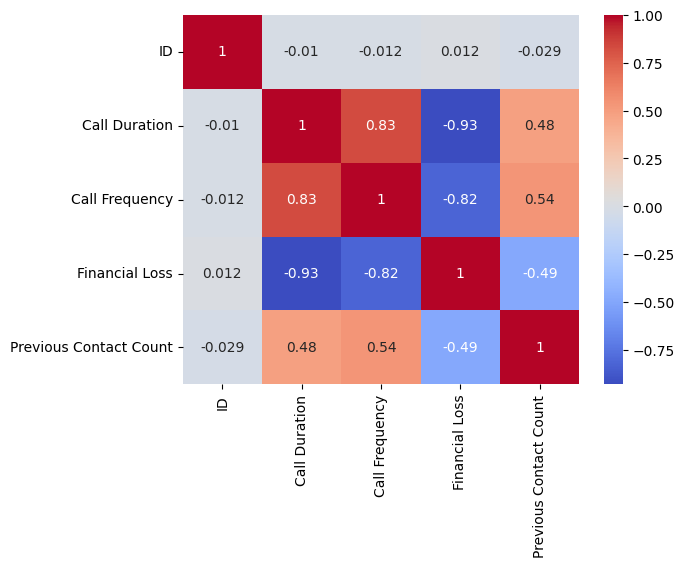

In [33]:
sns.heatmap(calls[nums].corr(),cmap='coolwarm',annot=True)

Notably due to scaling, we can see that values are closely correlated now so we can see a few values that we could use for feature selection

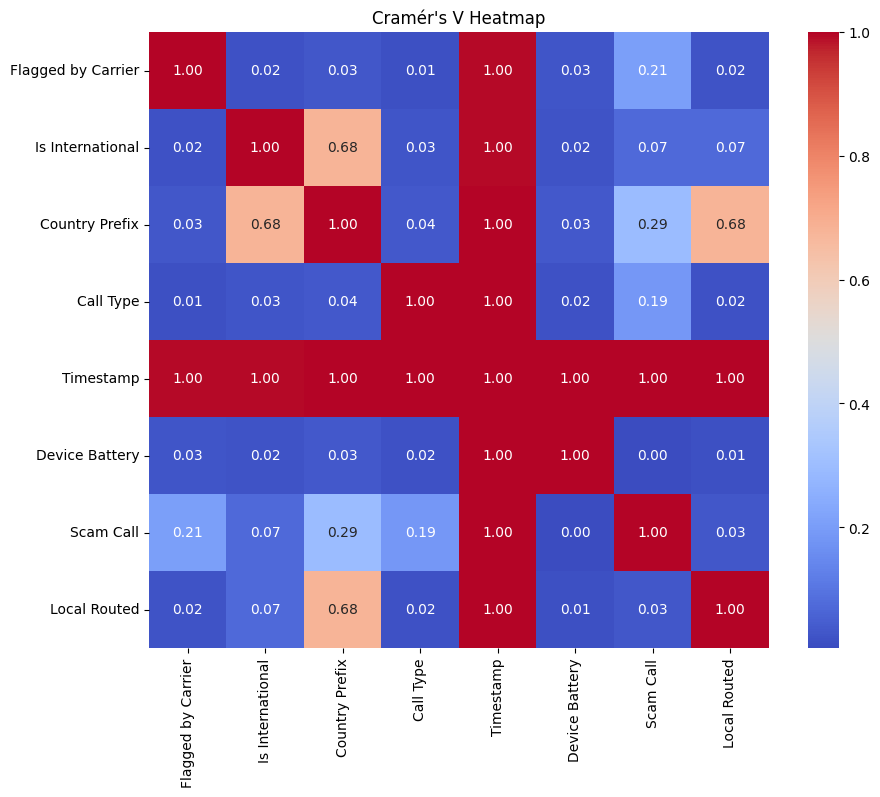

In [34]:
categorical_columns = calls.select_dtypes(include='object').columns
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)


for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(calls[col1], calls[col2])
            chi2, p, dof, ex = sp.stats.chi2_contingency(confusion_matrix)
            n = confusion_matrix.sum().sum()
            r, k = confusion_matrix.shape
            cramers_v = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
            cramers_v_matrix.loc[col1, col2] = cramers_v


cramers_v_matrix = cramers_v_matrix.astype(float)
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cramér's V Heatmap")
plt.show()

For categorical not much change as only numerical values were affected by scaling

C:\Users\yashv\AppData\Local\Temp\ipykernel_18936\3069731943.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



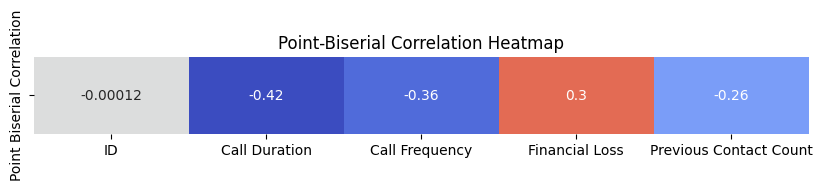

In [35]:
calls_num = calls.select_dtypes(include=['int64','float64'])
point_biserial_corr = {}
calls['Scam Call'] = calls['Scam Call'].replace({'Scam':1,'Not Scam':0})
for col in calls_num:
    corr, p_value = sp.stats.pointbiserialr(calls['Scam Call'], calls_num[col])
    point_biserial_corr[col] = corr

# Create a DataFrame for the heatmap
point_biserial_df = pd.DataFrame.from_dict(point_biserial_corr, orient='index', columns=['Point Biserial Correlation'])
# Plot heatmap
plt.figure(figsize=(10, 1))
sns.heatmap(point_biserial_df.T, annot=True, cmap='coolwarm', center=0, cbar=False)
plt.title("Point-Biserial Correlation Heatmap")
plt.show()


We can see vast improvements in the correlation values hence we chose the highest few, chosen features now: 

- `Call Frequency`
- `Previous Contact Count` 
- `Call Duration`
- `Flagged by Carrier` 
- `Country Prefix`   
- `Call Type`